# Imports

In [1]:
import numpy as np
import torch
from torch import nn
import pandas as pd
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import torchvision
import matplotlib.pyplot as plt
import os

# CUDA cores goes brrrrr

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

# Data pre-processing
## Loading data

In [3]:
letters = ["A", "B", "C", "L", "R", "U"]
data = []
removed_videos = {}

frames_per_video = 80

for letter in letters:
    
    removed_videos[letter] = []
    anno_df = pd.read_csv("data/ASL_letter_" + letter + "/annotations.csv")
    nr = 0
    while True:
            
        try:
            
            video = torchvision.io.read_video("data/ASL_letter_" + letter + "/videos/video_" + str(nr) + ".mp4")
            if video[0].shape[1] == 480 and video[0].shape[2] == 640:
                for i in range(frames_per_video):
                    frame = np.random.randint(0, video[0].shape[0])
                    
                    frame_df = anno_df.loc[np.logical_and(anno_df['video_idx'] == nr, anno_df['frame'] == frame)]
                    x = torch.tensor(frame_df['x'].values)
                    y = torch.tensor(frame_df['y'].values)

                    annotations = np.array([])
                    for i in range(x.shape[0]):
                        annotations = np.append(annotations, [x[i], y[i]])
                        
                    labels = [ 1 if x == letter else 0 for x in letters ]
                    labels = torch.tensor(labels, dtype=torch.float32)
                    
                    data.append((torch.tensor(annotations, dtype=torch.float32).to(device), labels.to(device)))
            else:
                removed_videos[letter].append(nr)
                
            nr += 1
            
        except RuntimeError:
            break

print("Success!")

C:\Users\ludvi\anaconda3\lib\site-packages\torchvision\io\video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
C:\Users\ludvi\anaconda3\lib\site-packages\torchvision\io\video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
C:\Users\ludvi\anaconda3\lib\site-packages\torchvision\io\video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
C:\Users\ludvi\anaconda3\lib\site-packages\torchvision\io\video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
C:\Users\ludvi\anaconda3\lib\site-packages\torch

Success!


## Splitting the data

In [4]:
split = 0.8
training_data = []
validation_data = []

total_videos = 0
for letter in letters:
    _, _, files = next(os.walk("data/ASL_letter_" + letter + "/videos"))
    file_count = len(files) - len(removed_videos[letter])
    training_data = training_data + data[total_videos*frames_per_video:total_videos*frames_per_video + frames_per_video*int(split*file_count)]
    validation_data = validation_data + data[total_videos*frames_per_video + frames_per_video*int(split*file_count):total_videos*frames_per_video + frames_per_video*file_count]
    total_videos += file_count

len(training_data), len(validation_data)

(12800, 3360)

# Pickle data

In [7]:
file = open('training_data2', 'wb')
pickle.dump(training_data, file)
file.close()

file = open('validation_data2', 'wb')
pickle.dump(validation_data, file)
file.close()

In [3]:
file = open('training_data2', 'rb')
training_data = pickle.load(file)
file.close()

file = open('validation_data2', 'rb')
validation_data = pickle.load(file)
file.close()

## Creating dataset class

In [4]:
class LandmarkDataset(torch.utils.data.Dataset):
    
    def __init__(self, d):
        self.data = d
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        datapoint = self.data[idx]
        return datapoint[0], datapoint[1]

## Creating dataloaders

In [5]:
batch_size = 1000

training_set = LandmarkDataset(training_data)
validation_set = LandmarkDataset(validation_data)

train_dataloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)

# Modelling

In [6]:
class SimpleANN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.ann = nn.Sequential(
            nn.Linear(42, 100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,6),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.ann(x)
    
model = SimpleANN().to(device)
model

SimpleANN(
  (ann): Sequential(
    (0): Linear(in_features=42, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=6, bias=True)
    (11): Sigmoid()
  )
)

# Training

In [7]:
optim = torch.optim.SGD(params=model.parameters(), lr=0.01)

print("Starting training...")

loss_fn = nn.BCELoss()

n_epochs = 100
for epoch in range(n_epochs):
    for i, (annotations, labels) in enumerate(train_dataloader):
        
        outputs = model(annotations)
        loss = loss_fn(outputs, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i % 25 == 0:
            print(f'Epoch: {epoch+1} \t Batch: {i+1} \t Loss: {loss.item()}')

print("Finished training")

Starting training...
Epoch: 1 	 Batch: 1 	 Loss: 0.9274559617042542
Epoch: 2 	 Batch: 1 	 Loss: 0.382354736328125
Epoch: 3 	 Batch: 1 	 Loss: 0.3263353109359741
Epoch: 4 	 Batch: 1 	 Loss: 0.2842007279396057
Epoch: 5 	 Batch: 1 	 Loss: 0.24717901647090912
Epoch: 6 	 Batch: 1 	 Loss: 0.2026127129793167
Epoch: 7 	 Batch: 1 	 Loss: 0.18061290681362152
Epoch: 8 	 Batch: 1 	 Loss: 0.15235492587089539
Epoch: 9 	 Batch: 1 	 Loss: 0.14831013977527618
Epoch: 10 	 Batch: 1 	 Loss: 0.14215128123760223
Epoch: 11 	 Batch: 1 	 Loss: 0.11294246464967728
Epoch: 12 	 Batch: 1 	 Loss: 0.11683312803506851
Epoch: 13 	 Batch: 1 	 Loss: 0.10055937618017197
Epoch: 14 	 Batch: 1 	 Loss: 0.08793552219867706
Epoch: 15 	 Batch: 1 	 Loss: 0.07741498947143555
Epoch: 16 	 Batch: 1 	 Loss: 0.07513013482093811
Epoch: 17 	 Batch: 1 	 Loss: 0.06444180011749268
Epoch: 18 	 Batch: 1 	 Loss: 0.061561960726976395
Epoch: 19 	 Batch: 1 	 Loss: 0.06089157983660698
Epoch: 20 	 Batch: 1 	 Loss: 0.053809113800525665
Epoch: 21 	 

In [12]:
# save the model
torch.save(model.state_dict(), "first_good_simpleann.pth")

In [ ]:
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('first_good_simpleann.pth'))

# Validation

In [8]:
with torch.no_grad():  # use no grad
    correct = 0
    for point in training_data:
        if torch.argmax(model(point[0])) == torch.argmax(point[1]):
            correct += 1
    correct_percent = correct / len(training_data)
    print(f"Training accuracy is: {correct_percent*100:.2f}%")
    
    # then the test accuracy
    correct = 0
    for point in validation_data:
        if torch.argmax(model(point[0])) == torch.argmax(point[1]):
            correct += 1
    correct_percent = correct / len(validation_data)
    print(f"Test accuracy is: {correct_percent*100:.2f}%")

Training accuracy is: 99.81%
Test accuracy is: 94.73%


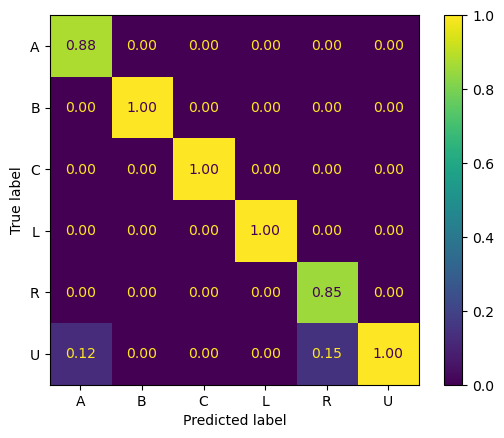

In [10]:
Y_true = np.array([])
Y_pred = np.array([])

letters = ["A", "B", "C", "L", "R", "U"]


for i in range(len(validation_set)):
    annotation, label = validation_set.__getitem__(i)
    Y_true = np.append(Y_true, torch.argmax(label).cpu())
    Y_pred = np.append(Y_pred, torch.argmax(model(annotation)).cpu())

ConfusionMatrixDisplay.from_predictions(
    Y_true,
    Y_pred, 
    normalize="pred",
    display_labels=letters,
    values_format=".2f"
)
plt.show()